<a href="https://colab.research.google.com/github/FernandaSzAdr/CNN_cromossome/blob/master/TesteRede2_Colorida_Base2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/




---



In [2]:
!pip install imutils

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from skimage import transform

import cv2
import csv
import imutils
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.




---



## Funções

In [0]:
train_path = 'drive/My Drive/Base_CNN/Colorido2/Train'
test_path = 'drive/My Drive/Base_CNN/Colorido2/Test'
validation_path = 'drive/My Drive/Base_CNN/Colorido2/Validation'

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao


In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  prob = []
  
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Resultado/Colorido/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    # Pega cada imagem separadamente do folder de teste
    image = cv2.imread(test_path + '/' + img)
    image = imutils.resize(image, width=1000)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          # Para cada região dessa imagem:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            
            # Label da região
            label = linha[1]
            if label == 'NC':
              y_true.append(0)
            else:
              y_true.append(1)
            
            # Região
            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)
            
            # Coloca a região na função e obtem o resultado
            predicao = model.predict(regiao,batch_size=bSize,verbose=0)
            
            # Probabilidade de ser da classe 1
            prob.append(predicao[0][1])
            
            # Se é um cromossomo:
            if predicao[0][1] > predicao[0][0]:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
            # Se não for um cromossomo:
            else:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict, prob




---



# Implementação

## Variaveis globais



*   Batch size = 32
*   Image size = 120x120



In [0]:
results = {}

In [0]:
bSize = 32

In [0]:
datagen = ImageDataGenerator(rescale=1/255.)

In [19]:
train_batches = datagen.flow_from_directory(train_path, target_size=(120, 120), 
                                            classes=['NC', 'C'], 
                                            batch_size=bSize)
validation_batches = datagen.flow_from_directory(validation_path, 
                                                 target_size=(120, 120), 
                                                 classes=['NC', 'C'], 
                                                 batch_size=bSize)

Found 4369 images belonging to 2 classes.
Found 991 images belonging to 2 classes.


In [0]:
stepsPerEpoche = len(train_batches)/bSize
validationSteps = len(validation_batches)/bSize

In [21]:
train_batches.class_indices

{'C': 1, 'NC': 0}



---



## 1 tentativa - Test Precision: 19.64%, AUC: 69.32%, Accuracy: 19.64%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"



In [0]:
architecture = 'architecture_1'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [26]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 96s - loss: 0.7635 - acc: 0.4312 - val_loss: 0.6947 - val_acc: 0.4375

Epoch 00001: val_loss improved from inf to 0.69471, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_1.hdf5
Epoch 2/50
 - 98s - loss: 0.6949 - acc: 0.4937 - val_loss: 0.7064 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 0.69471
Epoch 3/50
 - 92s - loss: 0.7283 - acc: 0.5000 - val_loss: 0.6784 - val_acc: 0.5938

Epoch 00003: val_loss improved from 0.69471 to 0.67836, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_1.hdf5
Epoch 4/50
 - 98s - loss: 0.7023 - acc: 0.4875 - val_loss: 0.6812 - val_acc: 0.6875

Epoch 00004: val_loss did not improve from 0.67836
Epoch 5/50
 - 99s - loss: 0.7017 - acc: 0.4562 - val_loss: 0.6893 - val_acc: 0.5625

Epoch 00005: val_loss did not improve from 0.67836
Epoch 6/50
 - 92s - loss: 0.7498 - acc: 0.4562 - val_loss: 0.6936 - val_acc: 0.5000

Epoch 00006: val_loss did not improve from 0.67836
Epoch 7/50
 - 92s - lo

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

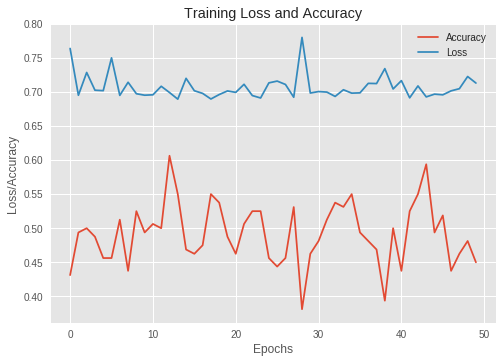

In [28]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [31]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [32]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 69.32%, Accuracy: 19.64%


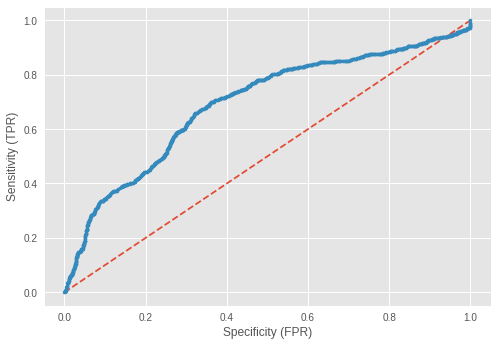

In [33]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 2 tentativa  - Test Precision: 40.96%, AUC: 84.74%, Accuracy: 73.28%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"
*   Alteração nas duas ultimas camadas Dense





In [0]:
architecture = 'architecture_2'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [38]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 2s - loss: 0.6933 - acc: 0.4813 - val_loss: 0.6931 - val_acc: 0.5161

Epoch 00001: val_loss improved from inf to 0.69310, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_2.hdf5
Epoch 2/50
 - 1s - loss: 0.6933 - acc: 0.5125 - val_loss: 0.6935 - val_acc: 0.4688

Epoch 00002: val_loss did not improve from 0.69310
Epoch 3/50
 - 1s - loss: 0.6938 - acc: 0.4355 - val_loss: 0.6927 - val_acc: 0.5938

Epoch 00003: val_loss improved from 0.69310 to 0.69272, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_2.hdf5
Epoch 4/50
 - 1s - loss: 0.6933 - acc: 0.4688 - val_loss: 0.6931 - val_acc: 0.5312

Epoch 00004: val_loss did not improve from 0.69272
Epoch 5/50
 - 1s - loss: 0.6931 - acc: 0.4750 - val_loss: 0.6934 - val_acc: 0.4688

Epoch 00005: val_loss did not improve from 0.69272
Epoch 6/50
 - 1s - loss: 0.6930 - acc: 0.5062 - val_loss: 0.6921 - val_acc: 0.6250

Epoch 00006: val_loss improved from 0.69272 to 0.69208, saving model to drive/M

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

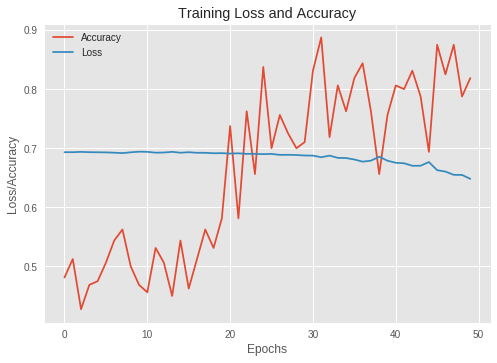

In [40]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [41]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [42]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 40.96%, AUC: 84.74%, Accuracy: 73.28%


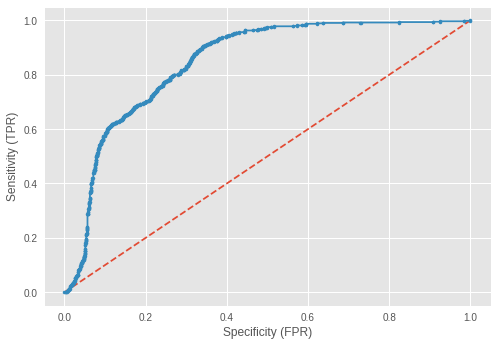

In [43]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 3 tentativa - Test Precision: 44.27%, AUC: 90.22%, Accuracy: 75.80%

Modelo criado pelo **Lucas Valentim**

https://github.com/lucasvalentim/chromosome-recognizer/blob/master/chromosome_recognizer.ipynb

In [0]:
architecture = 'architecture_3'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [48]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 1.2620 - acc: 0.5875 - val_loss: 0.7618 - val_acc: 0.6406

Epoch 00001: val_loss improved from inf to 0.76175, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_3.hdf5
Epoch 2/50
 - 1s - loss: 0.6353 - acc: 0.8000 - val_loss: 0.6502 - val_acc: 0.7581

Epoch 00002: val_loss improved from 0.76175 to 0.65018, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_3.hdf5
Epoch 3/50
 - 0s - loss: 0.6702 - acc: 0.8000 - val_loss: 1.2486 - val_acc: 0.7188

Epoch 00003: val_loss did not improve from 0.65018
Epoch 4/50
 - 0s - loss: 0.6053 - acc: 0.8281 - val_loss: 1.5399 - val_acc: 0.7188

Epoch 00004: val_loss did not improve from 0.65018
Epoch 5/50
 - 0s - loss: 0.4514 - acc: 0.8563 - val_loss: 0.7225 - val_acc: 0.7656

Epoch 00005: val_loss did not improve from 0.65018
Epoch 6/50
 - 1s - loss: 0.6603 - acc: 0.8059 - val_loss: 0.4527 - val_acc: 0.8125

Epoch 00006: val_loss improved from 0.65018 to 0.45274, saving model to drive/M

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

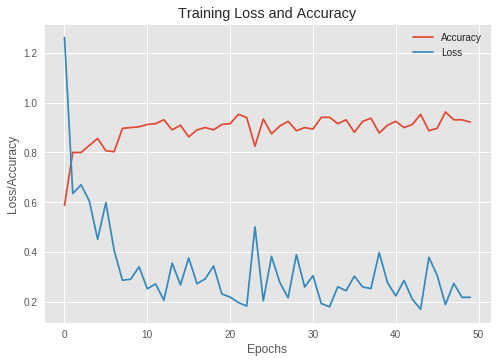

In [50]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [51]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [52]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 44.27%, AUC: 90.22%, Accuracy: 75.80%


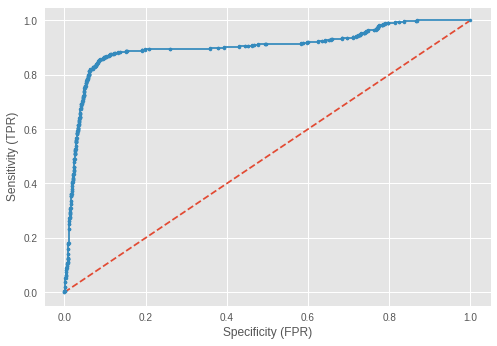

In [53]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 4 tentativa - Test Precision: 39.73%, AUC: 81.32%, Accuracy: 73.35%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**


In [0]:
architecture = 'architecture_4'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [58]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.6461 - acc: 0.7250 - val_loss: 1.1913 - val_acc: 0.6562

Epoch 00001: val_loss improved from inf to 1.19134, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_4.hdf5
Epoch 2/50
 - 0s - loss: 0.4647 - acc: 0.8281 - val_loss: 0.7066 - val_acc: 0.7188

Epoch 00002: val_loss improved from 1.19134 to 0.70656, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_4.hdf5
Epoch 3/50
 - 0s - loss: 0.3638 - acc: 0.8563 - val_loss: 0.7771 - val_acc: 0.8065

Epoch 00003: val_loss did not improve from 0.70656
Epoch 4/50
 - 0s - loss: 0.2862 - acc: 0.9219 - val_loss: 0.7829 - val_acc: 0.8125

Epoch 00004: val_loss did not improve from 0.70656
Epoch 5/50
 - 0s - loss: 0.2058 - acc: 0.9344 - val_loss: 0.8795 - val_acc: 0.7656

Epoch 00005: val_loss did not improve from 0.70656
Epoch 6/50
 - 0s - loss: 0.2260 - acc: 0.9250 - val_loss: 0.7534 - val_acc: 0.6250

Epoch 00006: val_loss did not improve from 0.70656
Epoch 7/50
 - 0s - loss: 0.2

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

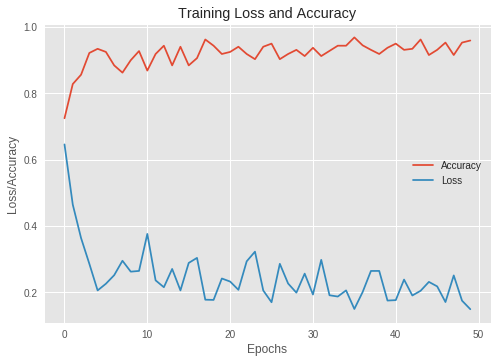

In [60]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [61]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [62]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 39.73%, AUC: 81.32%, Accuracy: 73.35%


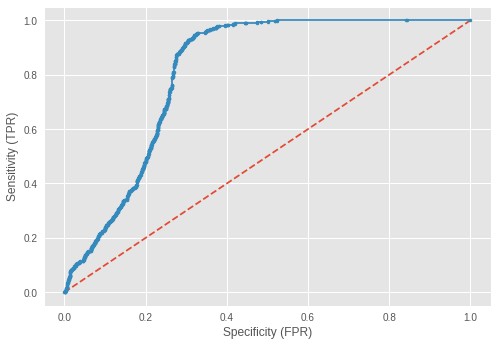

In [63]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 5 tentativa - Test Precision: 30.75%, AUC: 77.69%, Accuracy: 59.38%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_5'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [68]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 1.1311 - acc: 0.6469 - val_loss: 1.4223 - val_acc: 0.5625

Epoch 00001: val_loss improved from inf to 1.42235, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_5.hdf5
Epoch 2/50
 - 0s - loss: 1.1382 - acc: 0.6750 - val_loss: 0.9292 - val_acc: 0.6719

Epoch 00002: val_loss improved from 1.42235 to 0.92918, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_5.hdf5
Epoch 3/50
 - 0s - loss: 0.6331 - acc: 0.7656 - val_loss: 0.5187 - val_acc: 0.9062

Epoch 00003: val_loss improved from 0.92918 to 0.51866, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_5.hdf5
Epoch 4/50
 - 0s - loss: 0.6881 - acc: 0.7781 - val_loss: 0.5837 - val_acc: 0.6935

Epoch 00004: val_loss did not improve from 0.51866
Epoch 5/50
 - 0s - loss: 0.6089 - acc: 0.7500 - val_loss: 0.9352 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 0.51866
Epoch 6/50
 - 0s - loss: 0.5266 - acc: 0.8344 - val_loss: 0.7171 - val_acc: 0.79

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

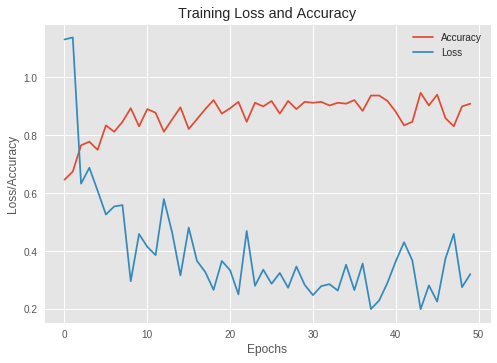

In [70]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [71]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [72]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 30.75%, AUC: 77.69%, Accuracy: 59.38%


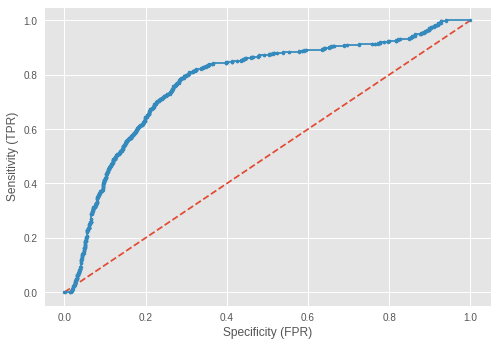

In [73]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 6 tentativa - Test Precision: 44.29%, AUC: 89.28%, Accuracy: 76.02%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_6'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [78]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.6520 - acc: 0.6750 - val_loss: 0.7814 - val_acc: 0.6719

Epoch 00001: val_loss improved from inf to 0.78144, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_6.hdf5
Epoch 2/50
 - 0s - loss: 0.4477 - acc: 0.8469 - val_loss: 1.1167 - val_acc: 0.4844

Epoch 00002: val_loss did not improve from 0.78144
Epoch 3/50
 - 0s - loss: 0.3732 - acc: 0.8594 - val_loss: 1.6741 - val_acc: 0.4062

Epoch 00003: val_loss did not improve from 0.78144
Epoch 4/50
 - 0s - loss: 0.3679 - acc: 0.8844 - val_loss: 1.6092 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.78144
Epoch 5/50
 - 0s - loss: 0.3373 - acc: 0.8781 - val_loss: 2.4013 - val_acc: 0.4194

Epoch 00005: val_loss did not improve from 0.78144
Epoch 6/50
 - 0s - loss: 0.3309 - acc: 0.8750 - val_loss: 1.0842 - val_acc: 0.5000

Epoch 00006: val_loss did not improve from 0.78144
Epoch 7/50
 - 0s - loss: 0.2129 - acc: 0.9437 - val_loss: 0.4631 - val_acc: 0.8281

Epoch 00007: val_loss impro

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

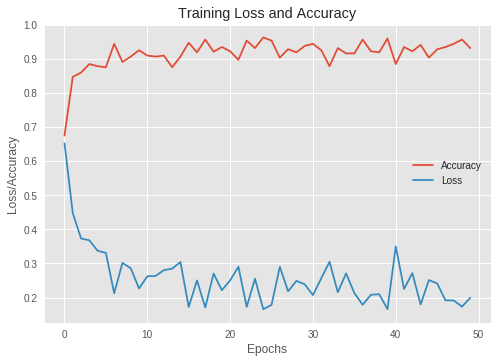

In [80]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [81]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [82]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 44.29%, AUC: 89.28%, Accuracy: 76.02%


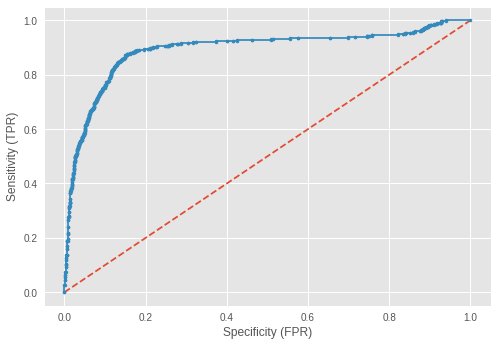

In [83]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 7 tentativa - Test Precision: 43.59%, AUC: 86.17%, Accuracy: 75.17%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **Adadelta** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_7'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [88]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.6352 - acc: 0.7031 - val_loss: 0.4067 - val_acc: 0.8125

Epoch 00001: val_loss improved from inf to 0.40666, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_7.hdf5
Epoch 2/50
 - 0s - loss: 0.3930 - acc: 0.8563 - val_loss: 2.1669 - val_acc: 0.5781

Epoch 00002: val_loss did not improve from 0.40666
Epoch 3/50
 - 0s - loss: 0.5216 - acc: 0.8187 - val_loss: 0.4817 - val_acc: 0.7500

Epoch 00003: val_loss did not improve from 0.40666
Epoch 4/50
 - 0s - loss: 0.3684 - acc: 0.8875 - val_loss: 0.6176 - val_acc: 0.7500

Epoch 00004: val_loss did not improve from 0.40666
Epoch 5/50
 - 0s - loss: 0.3438 - acc: 0.8625 - val_loss: 0.4246 - val_acc: 0.8438

Epoch 00005: val_loss did not improve from 0.40666
Epoch 6/50
 - 0s - loss: 0.3027 - acc: 0.8969 - val_loss: 0.7164 - val_acc: 0.8226

Epoch 00006: val_loss did not improve from 0.40666
Epoch 7/50
 - 0s - loss: 0.2557 - acc: 0.9219 - val_loss: 0.8288 - val_acc: 0.7031

Epoch 00007: val_loss did n

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

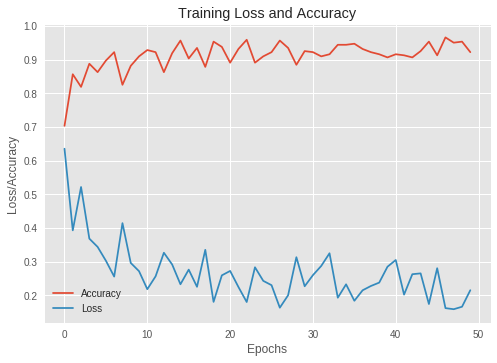

In [90]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [91]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [92]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 43.59%, AUC: 86.17%, Accuracy: 75.17%


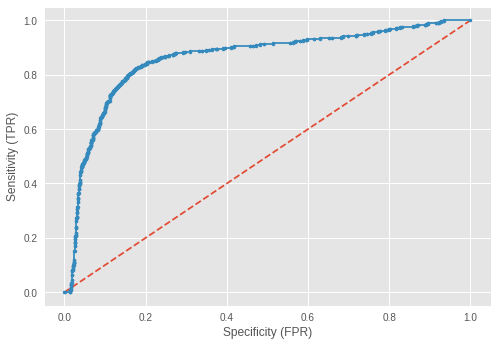

In [93]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 8 tentativa  - Test Precision: 46.31%, AUC: 82.69%, Accuracy: 78.11%

Modelo adaptado do **Lucas Valentim**

*   Função **Adadelta** para compilação


In [0]:
architecture = 'architecture_8'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [98]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 1.3367 - acc: 0.5687 - val_loss: 1.5211 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 1.52113, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_8.hdf5
Epoch 2/50
 - 1s - loss: 0.7431 - acc: 0.7375 - val_loss: 0.4198 - val_acc: 0.8438

Epoch 00002: val_loss improved from 1.52113 to 0.41983, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_8.hdf5
Epoch 3/50
 - 0s - loss: 0.6039 - acc: 0.7562 - val_loss: 1.0912 - val_acc: 0.6250

Epoch 00003: val_loss did not improve from 0.41983
Epoch 4/50
 - 0s - loss: 0.5301 - acc: 0.8500 - val_loss: 0.8647 - val_acc: 0.6562

Epoch 00004: val_loss did not improve from 0.41983
Epoch 5/50
 - 0s - loss: 0.3932 - acc: 0.8688 - val_loss: 0.4146 - val_acc: 0.8594

Epoch 00005: val_loss improved from 0.41983 to 0.41464, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_8.hdf5
Epoch 6/50
 - 0s - loss: 0.2585 - acc: 0.9062 - val_loss: 0.6921 - val_acc: 0.75

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

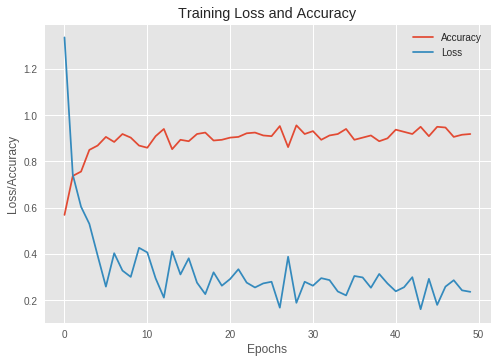

In [100]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [101]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [102]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 46.31%, AUC: 82.69%, Accuracy: 78.11%


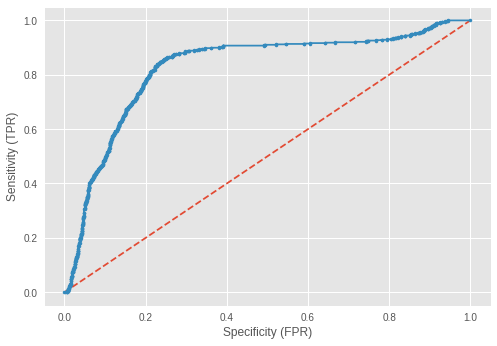

In [103]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 9 tentativa - Test Precision: 57.94%, AUC: 91.45%, Accuracy: 85.09%

Modelo adaptado do **Lucas Valentim**

*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_9'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [108]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 2.3373 - acc: 0.4719 - val_loss: 0.8572 - val_acc: 0.5781

Epoch 00001: val_loss improved from inf to 0.85724, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_9.hdf5
Epoch 2/50
 - 0s - loss: 0.6511 - acc: 0.7000 - val_loss: 0.6829 - val_acc: 0.6562

Epoch 00002: val_loss improved from 0.85724 to 0.68288, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_9.hdf5
Epoch 3/50
 - 0s - loss: 0.5109 - acc: 0.8000 - val_loss: 0.7738 - val_acc: 0.7031

Epoch 00003: val_loss did not improve from 0.68288
Epoch 4/50
 - 0s - loss: 0.4067 - acc: 0.8688 - val_loss: 0.5171 - val_acc: 0.7969

Epoch 00004: val_loss improved from 0.68288 to 0.51708, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_9.hdf5
Epoch 5/50
 - 0s - loss: 0.4252 - acc: 0.8440 - val_loss: 0.9944 - val_acc: 0.4219

Epoch 00005: val_loss did not improve from 0.51708
Epoch 6/50
 - 0s - loss: 0.5807 - acc: 0.7969 - val_loss: 0.4533 - val_acc: 0.82

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

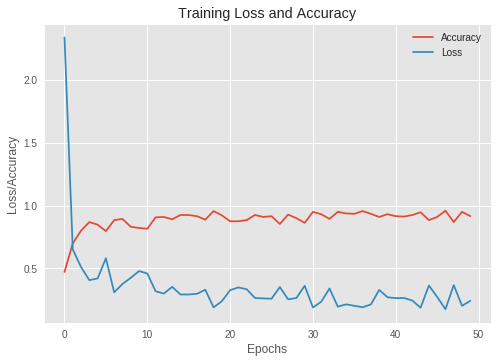

In [110]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [111]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [112]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 57.94%, AUC: 91.45%, Accuracy: 85.09%


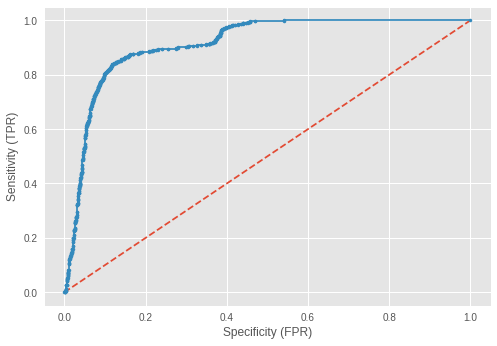

In [113]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 10 tentativa - Test Precision: 40.28%, AUC: 86.38%, Accuracy: 72.07%

Modelo adaptado do **Lucas Valentim**

*   Função **adam** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_10'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [118]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 1.4334 - acc: 0.5781 - val_loss: 0.8454 - val_acc: 0.6562

Epoch 00001: val_loss improved from inf to 0.84543, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_10.hdf5
Epoch 2/50
 - 1s - loss: 0.7329 - acc: 0.7625 - val_loss: 0.4858 - val_acc: 0.8906

Epoch 00002: val_loss improved from 0.84543 to 0.48579, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_10.hdf5
Epoch 3/50
 - 1s - loss: 0.4468 - acc: 0.8781 - val_loss: 0.2813 - val_acc: 0.8906

Epoch 00003: val_loss improved from 0.48579 to 0.28132, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_10.hdf5
Epoch 4/50
 - 1s - loss: 0.4901 - acc: 0.8281 - val_loss: 0.2330 - val_acc: 0.9375

Epoch 00004: val_loss improved from 0.28132 to 0.23299, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_10.hdf5
Epoch 5/50
 - 1s - loss: 0.2984 - acc: 0.9094 - val_loss: 0.5575 - val_acc: 0.7656

Epoch 00005: val_loss did not improve from 0

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

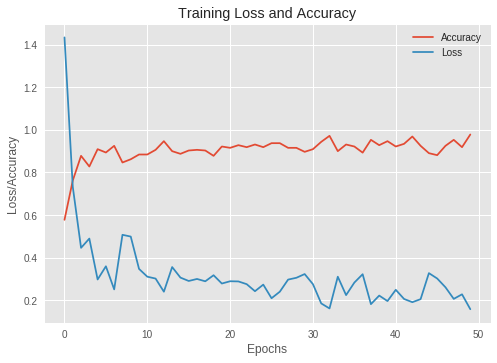

In [120]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [121]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [122]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 40.28%, AUC: 86.38%, Accuracy: 72.07%


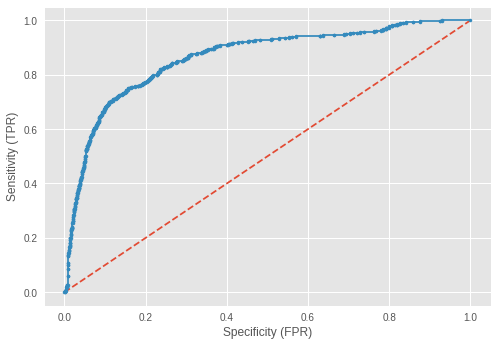

In [123]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 11 tentativa - Test Precision: 31.33%, AUC: 77.21%, Accuracy: 60.32%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_11'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [128]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 1.5314 - acc: 0.5625 - val_loss: 0.6537 - val_acc: 0.6875

Epoch 00001: val_loss improved from inf to 0.65368, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_11.hdf5
Epoch 2/50
 - 1s - loss: 0.7473 - acc: 0.7281 - val_loss: 0.6361 - val_acc: 0.6719

Epoch 00002: val_loss improved from 0.65368 to 0.63610, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_11.hdf5
Epoch 3/50
 - 1s - loss: 0.7283 - acc: 0.7438 - val_loss: 0.8745 - val_acc: 0.4688

Epoch 00003: val_loss did not improve from 0.63610
Epoch 4/50
 - 1s - loss: 0.5060 - acc: 0.8344 - val_loss: 1.1457 - val_acc: 0.5312

Epoch 00004: val_loss did not improve from 0.63610
Epoch 5/50
 - 1s - loss: 0.3915 - acc: 0.8563 - val_loss: 0.5456 - val_acc: 0.7812

Epoch 00005: val_loss improved from 0.63610 to 0.54558, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_11.hdf5
Epoch 6/50
 - 1s - loss: 0.4211 - acc: 0.8656 - val_loss: 0.5604 - val_acc: 0

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

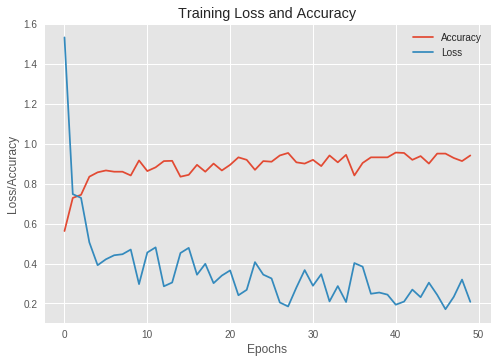

In [130]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [131]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [132]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 31.33%, AUC: 77.21%, Accuracy: 60.32%


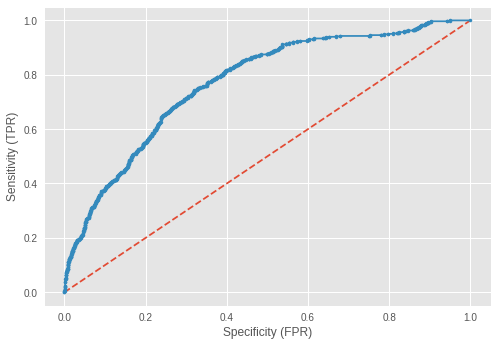

In [133]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 12 tentativa - Test Precision: 35.37%, AUC: 81.12%, Accuracy: 66.24%

Modelo adaptado do **Lucas Valentim**

*   Sem utilização das funções de regularização
*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_12'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [138]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 1.1505 - acc: 0.5844 - val_loss: 0.7528 - val_acc: 0.4375

Epoch 00001: val_loss improved from inf to 0.75284, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_12.hdf5
Epoch 2/50
 - 1s - loss: 0.8293 - acc: 0.6500 - val_loss: 0.7704 - val_acc: 0.5156

Epoch 00002: val_loss did not improve from 0.75284
Epoch 3/50
 - 1s - loss: 0.6600 - acc: 0.7188 - val_loss: 0.7128 - val_acc: 0.5000

Epoch 00003: val_loss improved from 0.75284 to 0.71284, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_12.hdf5
Epoch 4/50
 - 1s - loss: 0.5375 - acc: 0.7781 - val_loss: 0.6192 - val_acc: 0.6094

Epoch 00004: val_loss improved from 0.71284 to 0.61922, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_12.hdf5
Epoch 5/50
 - 1s - loss: 0.6482 - acc: 0.7344 - val_loss: 0.4742 - val_acc: 0.8438

Epoch 00005: val_loss improved from 0.61922 to 0.47420, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_1

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

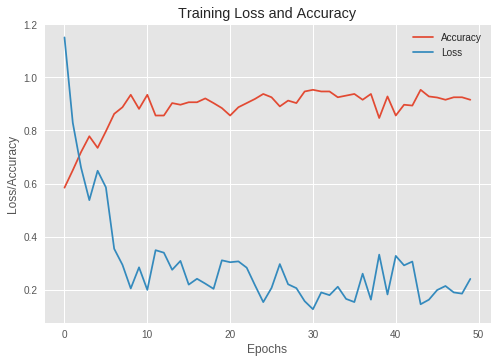

In [140]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [141]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [142]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 35.37%, AUC: 81.12%, Accuracy: 66.24%


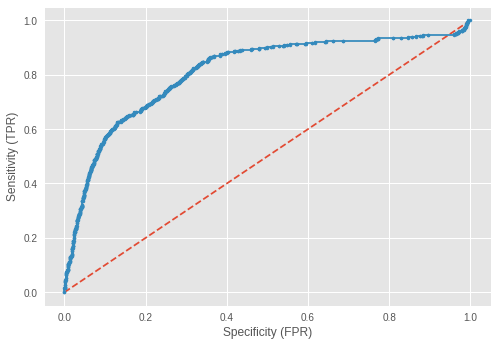

In [143]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 13 tentativa - Test Precision: 34.48%, AUC: 70.99%, Accuracy: 64.27%

Modelo adaptado do ** Lucas Valentim**

*   Utilizado outra função de normalização, diferente da utilizada por ele.

In [0]:
architecture = 'architecture_13'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (7, 7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [148]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 0.5947 - acc: 0.7719 - val_loss: 0.7332 - val_acc: 0.7500

Epoch 00001: val_loss improved from inf to 0.73318, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_13.hdf5
Epoch 2/50
 - 0s - loss: 0.5354 - acc: 0.8812 - val_loss: 0.3804 - val_acc: 0.8281

Epoch 00002: val_loss improved from 0.73318 to 0.38043, saving model to drive/My Drive/Resultado/Colorido/weights_architecture_13.hdf5
Epoch 3/50
 - 0s - loss: 0.3772 - acc: 0.8469 - val_loss: 1.3945 - val_acc: 0.6875

Epoch 00003: val_loss did not improve from 0.38043
Epoch 4/50
 - 0s - loss: 0.3707 - acc: 0.8719 - val_loss: 0.4474 - val_acc: 0.8125

Epoch 00004: val_loss did not improve from 0.38043
Epoch 5/50
 - 0s - loss: 0.3146 - acc: 0.8688 - val_loss: 0.4981 - val_acc: 0.8125

Epoch 00005: val_loss did not improve from 0.38043
Epoch 6/50
 - 1s - loss: 0.3002 - acc: 0.9094 - val_loss: 0.5076 - val_acc: 0.8125

Epoch 00006: val_loss did not improve from 0.38043
Epoch 7/50
 - 1s - loss: 0

In [0]:
model.load_weights('drive/My Drive/Resultado/Colorido/weights_' + architecture + '.hdf5')

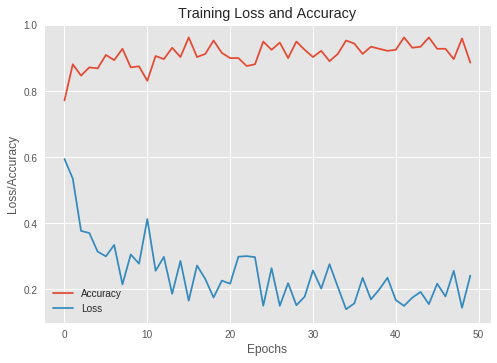

In [150]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Colorido/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [151]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [152]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 34.48%, AUC: 70.99%, Accuracy: 64.27%


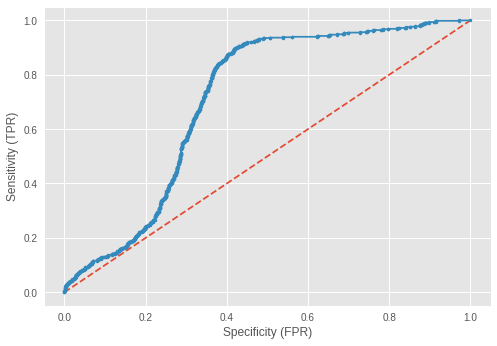

In [153]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Colorido/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')